# Network Intrusion Detection in Netflow using RAPIDS LODA

## Introduction 
In this workflow, we show how to use `Loda` anomaly detector for intrusion detection usecase. Loda is trained to identify attacks in the form of bots in Netflow data. We use [cic_ids2017](https://www.unb.ca/cic/datasets/ids-2017.html) benchmark dataset for the evaluation. For training, we use the activities collected from Monday that don't have any attacks on it. For evaluation, we use Friday flow data that is a mix of flows of benign and bot attacks.

In [ ]:
%config IPCompleter.use_jedi = False
import pandas as pd 
import cupy as cp 
import cudf
import cuml
import matplotlib.pylab as plt 
import os 
from cuml.decomposition import PCA as cu_pca
from itertools import permutations
from clx.analytics.loda import Loda
from util import metrics, average_precision_score, plot_pr, plot_roc
%matplotlib inline
cp.random.seed(101)

#### Load and preprocess dataset

Download `GeneratedLabelledFlows.zip` from the above link and extract all files in a selected path.

In [5]:
dir_path = "put/path/extracted/cic_ids2017/"
datasets = os.listdir(dir_path)

In [6]:
def load_dataset(dir_path):
    df = cudf.read_csv(dir_path) 
    df.columns = [ '_'.join(col.split()) for col in df.columns.str.strip()]
    return df
def drop_nonunique_features(df, nunique=1):
    # drop features with less than 2 unique variables. 
    var_col = []
    for i in df.columns:
        if df[i].value_counts().nunique() <= nunique:
            var_col.append(i)
    return df.drop(var_col, axis=1, inplace=False)
def remove_naninf(df):
    # Remove nan, inf rows. 
    temp_df = df.select_dtypes('float64')
    na_rows = temp_df.isin([cp.inf, cp.nan, -cp.inf]).any(1)
    return df[~na_rows]
    

We use the `Monday-WorkingHours` dataset for fitting a `Loda` model, this flow dataset doesn't have any attacks. For evaluation, we test the trained `Loda` model on activities that contain both benign and attacks. We use `Friday-WorkingHours-Morning` that has an attack in the form of bots.

In [7]:
# Training days
mon_df = load_dataset(os.path.join(dir_path, "Monday-WorkingHours.pcap_ISCX.csv")).pipe(drop_nonunique_features).pipe(remove_naninf).to_pandas()

# Testing days 
frid_df = load_dataset(os.path.join(dir_path, "Friday-WorkingHours-Morning.pcap_ISCX.csv")).pipe(drop_nonunique_features).pipe(remove_naninf).to_pandas()


In [8]:
# Proportion of anomalies in test data 
print(f"Proportion of Benign to Bots class in the evaluation dataset\n {frid_df.Label.value_counts() / frid_df.shape[0]}")

Proportion of Benign to Bots class in the evaluation dataset
 BENIGN    0.989754
Bot       0.010246
Name: Label, dtype: float64


#### Feature extraction and transformation methods.
We tried two approaches to transform the categorical features, such as `Source_IP`, `Destination_IP`, `Source_Port`, `Destination_Port` into numerical features.
1. Transform categorical features into count/frequency format.

In [9]:
def frequent_encoding(features, df):
    
    # Econde the categorical values based on the frequency of usage normalized over all rows.
    for feature in features:
        num_unique = df[feature].nunique()
        freq_count = df.groupby(feature)[feature].count()/ num_unique
        df[feature] = df[feature].map(freq_count)
        df[feature]  = (df[feature] - df[feature].min())/(df[feature].max() - df[feature].min())
    return onehot_encode('Protocol', df)

def onehot_encode(feature, df):
    dum_protocol = cudf.get_dummies(df, columns=[feature], prefix=[feature])
    protocol = dum_protocol.iloc[:, -3:] # hard coded. 
    df = cudf.concat([df, protocol], axis=1)
    return df.drop(feature, inplace=False, axis=1)

2. Compute entropy of categorical values based on subgroups formed from other related categorical feature.

$$H(X) = -\sum_{x_i \in X} p(x_i) \log p(x_i)$$ Where $p(x_i) = \frac{count(x_i)}{count(X)}$

We compute the entropy of sub-groups formed from `['Source_IP', 'Destination_IP', 'Source_Port', 'Destination_Port']` and compute all pairwise pairwise entropy among each other. Then the new numerical features are append to the original dataframe.

In [10]:
def entropy(series, base=None):
    vc = series.value_counts(normalize=True, sort=False)
    return -(vc * np.log(vc)/np.log(series.shape[0])).sum()
def encode_entropy(df, feature , target):
    feature_entropy = df.groupby(feature).agg(**{
        target+"_"+feature: (target, entropy)
        })
    return df.join(feature_entropy, on=feature, rsuffix="r_")

In [11]:
cat_features = ['Source_IP', 'Destination_IP', 'Source_Port', 'Destination_Port']

In [12]:
# Encode based on entropy of pairwise of categorical features.
for feature, target in permutations(cat_features,2):
    print(feature, target)
    mon_df = encode_entropy(mon_df, feature, target)
    frid_df = encode_entropy(frid_df, feature, target)



Source_IP Destination_IP
Source_IP Source_Port
Source_IP Destination_Port
Destination_IP Source_IP
Destination_IP Source_Port
Destination_IP Destination_Port
Source_Port Source_IP
Source_Port Destination_IP
Source_Port Destination_Port
Destination_Port Source_IP
Destination_Port Destination_IP
Destination_Port Source_Port


In [23]:
def remove_categorical_features(df):
    """
    Remove categorical features from the cic dataset
    """
    df = df.select_dtypes(['float64','int64'])
    return df.drop(["Protocol", "Source_Port", "Destination_Port"], axis=1, inplace=False)

def remove_correlated_features(df):
    """
    Remove features that are highly correlated. Mostly remove derived features.
    param df: pd.DataFrame
    """
    corr_mat = df.corr()
    # Select upper triangle of correlation matrix
    upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    return to_drop, df.drop(to_drop, inplace=False, axis=1)

Now remove all highly correlated features and extract label from test data for evaluation.

In [24]:
# Training data
X_train = remove_categorical_features(mon_df)
removed_cols, X_train = remove_correlated_features(X_train)


In [25]:
# Test data
label = (frid_df['Label']=="BENIGN").astype(int)
X_test = remove_categorical_features(frid_df)
X_test.drop(removed_cols, inplace=True, axis=1)

In [26]:
# Frequent_encoding 
#X_test = frequent_encoding(['Source IP', 'Destination IP', 'Source Port', 'Destination Port'], X_test.copy())

In [27]:
# Normalize if needed. 
normalize = lambda x : (x - x.min()) /(x.max() - x.min() + 0.0000001)


In [28]:
# Transform back from pandas to cudf to work with Loda. 
X_train = cudf.from_pandas(X_train)
X_test = cudf.from_pandas(X_test)

#### Train and test anomaly detector

Now we fit a `Loda` to the training dataset. We can simply train the anomaly detector and generate scores from the trained model. For this experiment, we will fit the clean data from `Monday working hours` and generate scores for the `Friday working hours`

We train `Loda` algorithm with `number_random_cuts=1000`.

In [84]:
ld = Loda(n_random_cuts=1000)
ld.fit(X_train.values)
x_scores = ld.score(X_test.values)

#### Model evaluation

Following is the AUC (Area under ROC curve) and average precision (AP) scores of the test data. 

In [87]:
auc, ap = metrics(label, x_scores)

In [88]:
print(f"AUC: {auc} and Average precision (AP): {ap}")

AUC: 0.5286834239959717 and Average precision (AP): 0.991349485858245


AP is good but AUC is poor, we can improve this by reducing some of the noisy features. One way is to use PCA to remove irrelevant feature, it improves the performance by reducing the noise features.

#### Removing redundant features using PCA
We use `cudf` PCA implementation as follows. 

In [80]:
def pca_loda(x_train, x_test, variance):
    
    x_train, n_component = pca_transform(x_train, variance=variance)
    x_test  = cu_pca(n_components=n_component, whiten=False).fit_transform(x_test)
    
    loda_pca = Loda(n_random_cuts=500)
    loda_pca.fit(x_train)
    loda_score = loda_pca.score(x_test)
    return metrics(label, loda_score), loda_score, n_component

def pca_transform(df, variance=0.99):
    """Apply PCA and keep #components with #variance kept"""
    pca = cu_pca(n_components=df.shape[1])
    pca_xtrain = pca.fit_transform(df)
    variance_exp = cp.cumsum(pca.explained_variance_ratio_)
    n_components = variance_exp<=variance
    return pca_xtrain[:,n_components], sum(n_components)

In [72]:
ap_auc, pca_scores, n_components_used = pca_loda(X_train.values, X_test.values, variance=0.999) 

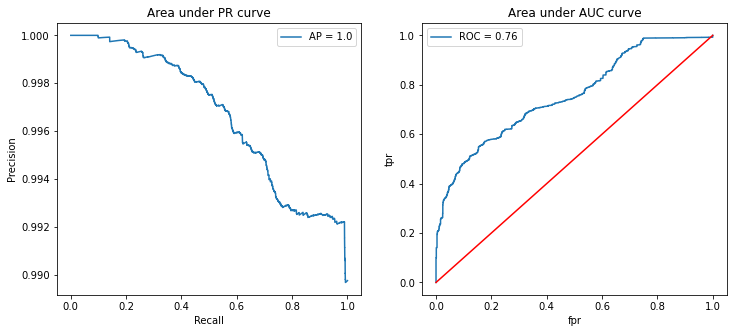

In [78]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_pr(label, pca_scores)
plt.subplot(1,2,2)
plot_roc(label, pca_scores)

In [79]:
print(f"Total number features used {n_components_used}")

Total number features used 11


## Summary
In this notebook, we show a proof of concept of applying the GPU accelerated Loda algorithm for Intrusion detection use cases. We evaluated the performance of the algorithm on the public intrusion detection dataset to identify attacks in the form of bots. We show the result both on raw data and noise-reduced features. The metrics (AUC and AP) shows the Loda algorithm can be used as an effective tool to identify attack for intrusion detection use case.

### Reference
- Sharafaldin, I.,Lashkari, A. H., & Ghorbani, A. A. (2018, January). Toward generating a new intrusion detection dataset and intrusion traffic characterization
- Pevný, T. (2016). Loda: Lightweight on-line detector of anomalies. Machine Learning